# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 5
# Logistic Regression and PCA 

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): E109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline

## Cancer Classification from Gene Expressions

In this homework assignment, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following parts, we will use logistic regression to build a classification model for this data set. We will also use principal components analysis (PCA) to visualize the data and to reduce its dimensions. 



## Part (a): Data Exploration

- First step is to split the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).


- Take a peak at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


- Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?


- A convenient tool to visualize the gene expression data is a heat map. Arrange the rows of the training set so that the 'AML' rows are grouped together and the 'ALL' rows are together. Generate a heat map of the data with expression values from the following genes: 
`D49818_at`, `M23161_at`, `hum_alu_at`, `AFFX-PheX-5_at`, `M15990_at`. By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.


- We can also visualize this data set in two dimensions using PCA. Find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the AML and ALL points in different colors. How well do the top two principal components discriminate between the two classes?



In [2]:
# split consistent with rest of class
np.random.seed(9001)

path = 'D:/' #'/Volumes/EMTEC/' # 'D:/'
df = pd.read_csv(path + 'dataset_hw5.csv')
msk = np.random.rand(len(df)) < 0.5
df_train = df[msk]
df_test = df[~msk]

print('''
Training Data Shape:
%s

Testing Data Shape:
%s
''' %(df_train.shape, df_test.shape))


Training Data Shape:
(32, 7130)

Testing Data Shape:
(41, 7130)



In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# split x/y train/test
predictor_cols = [col for col in df_train.columns if col != 'Cancer_type']
x_train, y_train = df_train[predictor_cols], df_train['Cancer_type']
x_test, y_test = df_test[predictor_cols], df_test['Cancer_type']

def scale_minmax(x_train, x_test, predictor_cols):
    '''
    Inputs:
    -------------------------------------------------
    x_train: raw training data
    x_test: raw testing data
    predictor_cols: columns that are not labels
    
    Outputs:
    -------------------------------------------------
    x_train: scaled minmax training data
    x_test: scaled minmax testing data
    '''
    # save train/test index for merging later
    ix_train, ix_test = x_train.index.values, x_test.index.values
    
    # scale minmax
    mm_scaler = MinMaxScaler()
    mm_scaler.fit(x_train)
    x_train, x_test = mm_scaler.transform(x_train), mm_scaler.transform(x_test)
    
    # save as dataframe
    x_train = pd.DataFrame(x_train, columns=predictor_cols, index=ix_train)
    x_test = pd.DataFrame(x_test, columns=predictor_cols, index=ix_test)
    
    return x_train, x_test

x_train, x_test = scale_minmax(x_train, x_test, predictor_cols)
x_train.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.466192,0.596552,0.487535,0.318182,0.369800,0.366279,0.644599,0.644860,0.928074,0.679435,...,0.488525,0.307918,0.398126,0.363988,0.677778,0.385555,0.322609,0.843750,0.088995,0.570896
5,0.727758,0.803448,0.684211,0.139205,0.548536,0.707849,0.411847,0.759346,0.338747,0.405242,...,0.039344,0.097507,0.831382,0.175218,0.777778,0.118959,0.072174,0.746528,0.012316,0.410448
9,0.000000,0.389655,0.542936,0.923295,0.203390,0.604651,0.476655,0.719626,0.570766,0.646169,...,0.672131,0.823314,0.988290,0.234269,1.000000,0.867764,1.000000,0.930556,0.221692,0.399254
12,0.877224,0.334483,0.677285,0.687500,0.420647,0.590116,0.732404,0.586449,0.357309,0.944556,...,0.619672,0.681085,0.435597,0.189739,0.625926,0.725969,0.258261,0.902778,0.229638,0.649254
13,0.590747,0.437931,0.350416,0.443182,0.591680,0.672965,0.423693,1.000000,0.635731,0.269153,...,0.219672,0.369501,0.662763,0.022265,0.911111,0.074881,0.134783,0.690972,0.021851,0.626866


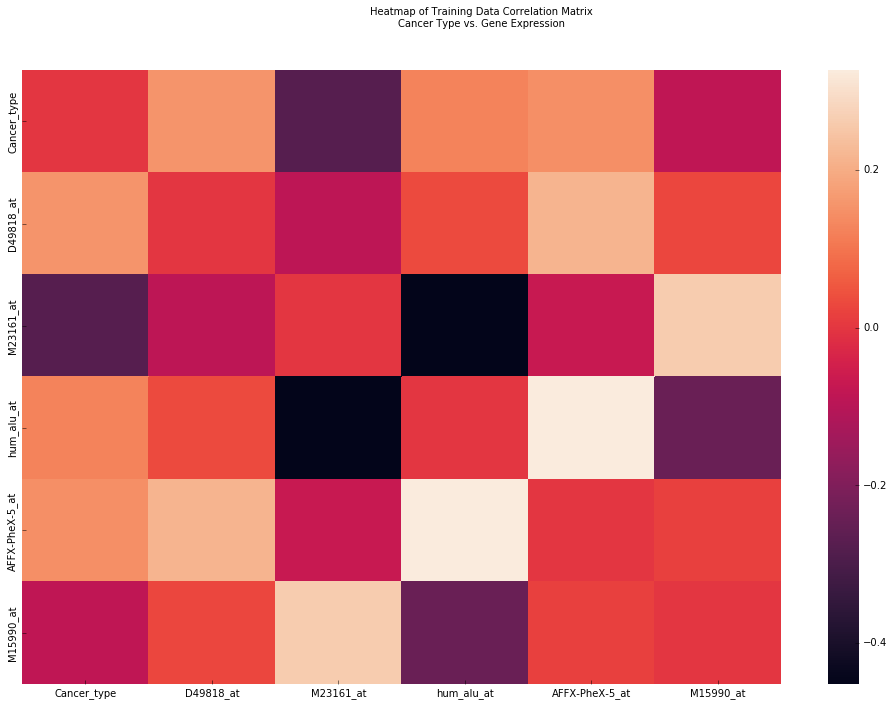

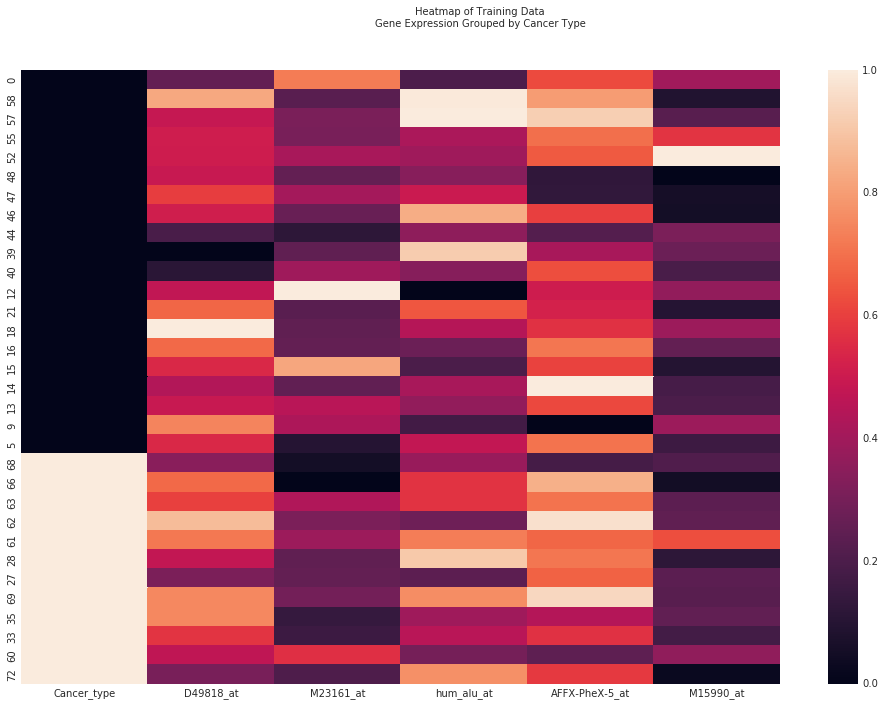

In [4]:
import seaborn as sns

# copy dataframe, scale them and select columns
df_train_scaled = df_train.copy()
df_train_scaled[predictor_cols] = MinMaxScaler().fit_transform(df_train_scaled[predictor_cols])
viz_cols = ['Cancer_type', 'D49818_at', 'M23161_at', 'hum_alu_at', 'AFFX-PheX-5_at', 'M15990_at']
df_train_scaled = df_train_scaled[viz_cols]

# use sns.heatmap to visualize
df_train_scaled = df_train_scaled.sort_values('Cancer_type')

# get correlation matrix for context
df_train_scaled_corr = df_train_scaled.corr()
np.fill_diagonal(df_train_scaled_corr.values, np.zeros(len(df_train_scaled_corr)))

# show correlation matrix first
fig, ax = plt.subplots(figsize=(17,11))
sns.heatmap(df_train_scaled_corr)
sns.color_palette('PuBuGn_d')
plt.suptitle('Heatmap of Training Data Correlation Matrix\nCancer Type vs. Gene Expression')
plt.style.use('seaborn-whitegrid')

# then sorted rows for context
fig, ax = plt.subplots(figsize=(17,11))
sns.heatmap(df_train_scaled)
sns.color_palette('PuBuGn_d')
plt.suptitle('Heatmap of Training Data\nGene Expression Grouped by Cancer Type')
plt.style.use('seaborn-whitegrid')

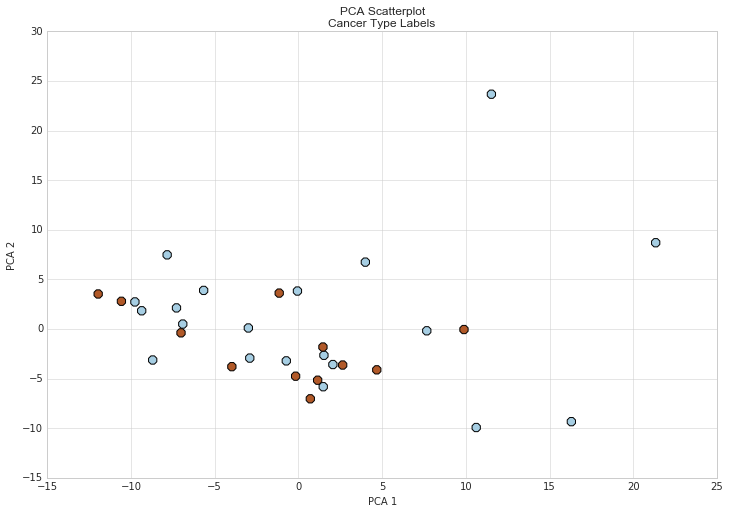

In [5]:
def generate_pca(x_train, n_pca):
    '''
    Compiles one training/test set of PCAs for each component in list
    
    Inputs:
    -------------------------------------------------
    x_train: original dataset of predictors to transform
    n_pca: number of PCAs to return OR percentage of variance to cover
    
    Outputs:
    -------------------------------------------------
    x_pca: pd.DataFrame of n_pca's derived from x_train
    '''
    # specify pca col names
    pca_cols = ['pca_' + str(n) for n in range(1, n_pca+1)]
    
    pca = PCA(n_components=n_pca)
    pca.fit(x_train)
    x_pca = pd.DataFrame(pca.transform(x_train), columns=pca_cols, index=x_train.index.values)
    
    return x_pca

# generate principal components
x_train_pca = generate_pca(x_train, n_pca=2)

# map back in cancer type to ensure accuracy
x_train_pca = x_train_pca.reset_index(drop=False)
x_train_pca.rename(columns={'index':'Cancer_type'}, inplace=True)

# send y_train to dictionary to map in by index
cancer_type = y_train.to_dict()
x_train_pca['Cancer_type'] = x_train_pca['Cancer_type'].map(cancer_type)

# plot scatterplot with colors to indicate type
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x_train_pca['pca_1'], x_train_pca['pca_2'], c=x_train_pca['Cancer_type'], \
           cmap='Paired', marker='8', s=80)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('PCA Scatterplot\nCancer Type Labels')
plt.style.use('seaborn-whitegrid')

### Caution When Fitting Classification Model with $P > N$

While it is entirely possible to fit a good model where the number of predictors $P$ is greater than the number of observations $N$, the process must be done with care to avoid a nonsensical model.

When there are more predictors than observations it is entirely possible that the problem does not have a unique solution. In such a case dimensionality reduction and/or regularization methods may be warranted to avoid over-fitting to the training data. This is true because highly flexible models (i.e. high numbers of predictors), when combined with smaller numbers of observations, increase the likelihood of standard regression techniques fitting models to the random fluctuations in the data. These patterns may or may not reflect the underlying distribution of the phenomena for which we seek to describe.

This issue can be addressed by constraining the problem, which is explored in subsequent sections.

### Top Two Principal Components

Generating the top two principal components from the standardized data does not appear to be a good mechanism for discriminating between the two cancer types.  Shown in the plot above, it is clear that using these two components only does little to distiniguish the cancer types based on the fact that the two are highly intermingled on the scatterplot.

### Heatmap of Selected Genes vs. Cancer Type

Two heatmaps are generated to explore which genes are useful in discriminating between `AML` and `ALL` cancer types.  The first is a simple correlation matrix, and the second is just the data grouped by cancer type.  

Based on the first heatmap of the correlation matrix it is observed that the genes `hum_alu_at`, `D49818_at` and `AFFX_PheX-5_at` all have positive correlations with $Y=1$, all hovering around 0.2 or less.  The gene `M15990_at` has a relatively weak negative relationship with $Y=1$.  Finally, the most useful distinguishing gene is the absence of `M23161_at`, which has a strong negative correlation somewhere near -0.3.

The second heatmap is a bit more difficult to interpret, and highlights the variation in gene expression within cancer types. It is interesting to note that, given the entire dataset presumably has some sort of cancer, the genes `M15990_at` and `M23161_at` both have relatively low expression values throughout the training observations, whereas the converse is true for `AFFX-PheX-5_at` which appears to exhibit higher expression values throughout the dataset.  This curiosity inducing observation could be explored further to research the roles of these genes in both cancer types in this data, assuming the same patterns are observed in larger observation datasets.

## Part (b): Linear Regression vs. Logistic Regression

Begin by analyzing the differences between using linear regression and logistic regression for classification. For this part, you shall work with a single gene predictor: `D29963_at`.

- Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by regression model interpreted for a patient as an estimate of the probability that the patient has the `ALL` type cancer (class 1). Is there a problem with this interpretation?


- The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into the `ALL` type (class 1), and the others into the `AML` type (class 0). Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.


- Next, fit a simple logistic regression model to the training set. How does the training and test calssification accuracy of this model compare with the linear regression model?  Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order not to regularize (use 'C=100000').



- Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot.
Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.



Simple Linear Regression
-------------------------------------------------- 


Converting Linear Regression to Classification Model
--------------------------------------------------


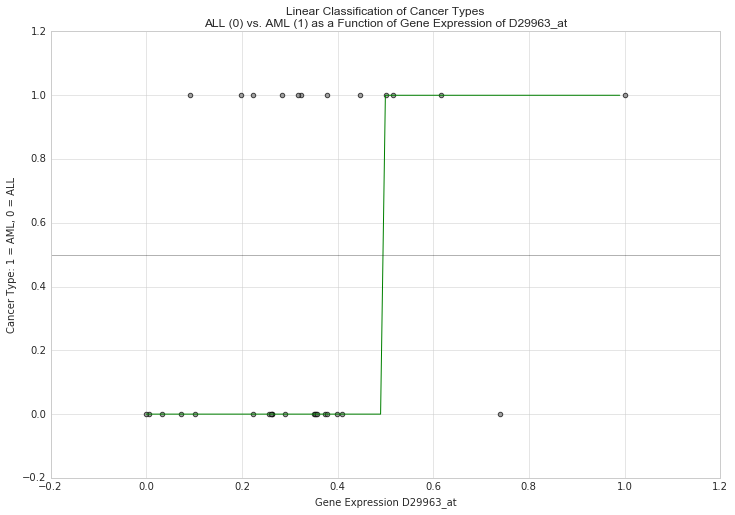

In [6]:
from sklearn.metrics import zero_one_loss
from sklearn.linear_model import LinearRegression

print('Simple Linear Regression')
print('-'*50, '\n\n')

linear = LinearRegression()
linear.fit(x_train['D29963_at'].reshape(-1, 1), y_train)

print('Converting Linear Regression to Classification Model')
print('-'*50)

# get classes from regression output
x_sorted = np.arange(0, 1, 0.01)
yhat_class = [0 if y < 0.5 else 1 for y in linear.predict(x_sorted.reshape(-1, 1))]

# plot outcomes
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x_train['D29963_at'], y_train, c='gray', alpha=0.7)
ax.plot(x_sorted, yhat_class, c='green')
ax.axhline(0.5, c='black', alpha=0.3)
ax.set_xlabel('Gene Expression D29963_at')
ax.set_ylabel('Cancer Type: 1 = AML, 0 = ALL')
ax.set_title('Linear Classification of Cancer Types\nALL (0) vs. AML (1) as a Function of Gene Expression of D29963_at')
plt.style.use('seaborn-whitegrid')

Simple Logistic Regression vs. Linear Regression
--------------------------------------------------

Logistic Regression Classifier
-------------------------------------------
Training Misclassification Rate:  0.28125
Testing Misclassification Rate:  0.17073


Linear Regression Classifier
-------------------------------------------
Training Misclassification Rate:  0.28125
Testing Misclassification Rate:  0.17073



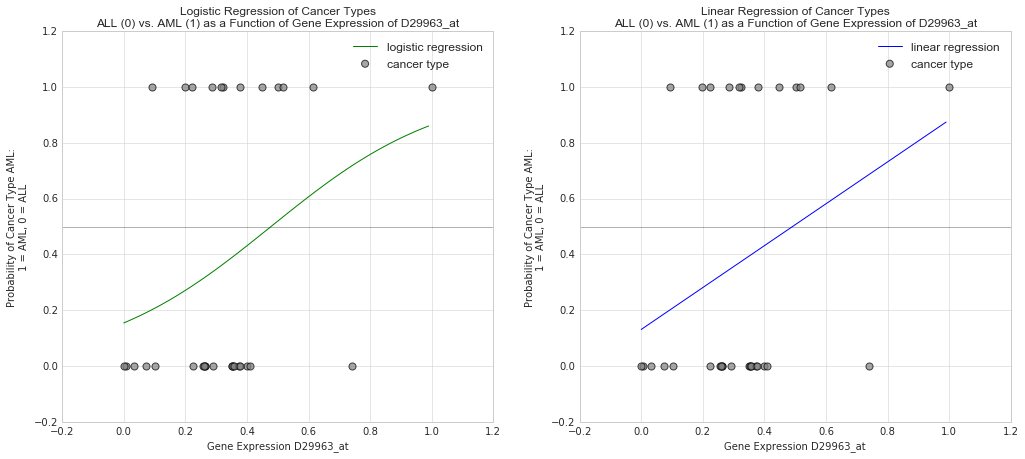

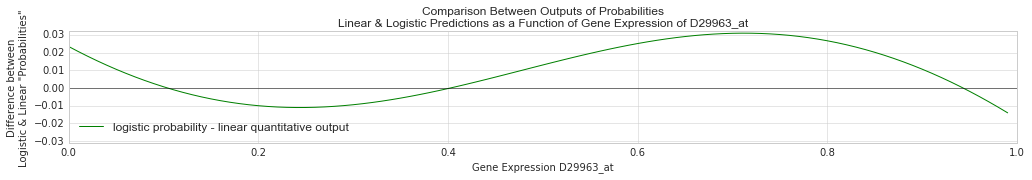

In [7]:
print('Simple Logistic Regression vs. Linear Regression')
print('-'*50)

# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

def misclassification_rate(y_train, y_hat):
    '''
    Inputs:
    -------------------------------------------------
    y_train: true labels
    y_hat: predicted labels
    
    Outputs:
    -------------------------------------------------
    error_rate: misclassification rate
    '''
    
    error_rate = zero_one_loss(y_train, y_hat)
    
    return error_rate

def sk_logistic_regression(x_train, y_train, C):
    '''
    Inputs:
    -------------------------------------------------
    x_train: training features
    y_train: training labels
    C: inverse of regularization lambda value
    
    Outputs:
    -------------------------------------------------
    logit: sklearn.linear_model.LogisticRegression fit model
    '''
    
    logit = LogisticRegression(C=C)
    logit.fit(x_train, y_train)
    
    return logit

# run logistic regression
logistic = sk_logistic_regression(x_train['D29963_at'].reshape(-1, 1), y_train, C=100000)

# get logistic predictions
xpredict = np.arange(0, 1, .01)
phat_logit = logistic.predict_proba(xpredict.reshape(-1, 1)).T[1]
yhat_logit = logistic.predict(x_train['D29963_at'].reshape(-1, 1))
yhat_logit_test = logistic.predict(x_test['D29963_at'].reshape(-1, 1))

# get misclassification rates on train/test for logistic regression
misclass_rate_train_log = misclassification_rate(y_train, yhat_logit)
misclass_rate_test_log = misclassification_rate(y_test, yhat_logit_test)

print('''
Logistic Regression Classifier
-------------------------------------------
Training Misclassification Rate:  %.5f
Testing Misclassification Rate:  %.5f
''' %(misclass_rate_train_log, misclass_rate_test_log))

# get test/train set class
yhat_linear = [int(0) if y < 0.5 else int(1) for y in linear.predict(x_train['D29963_at'].reshape(-1, 1))]
yhat_linear_test = [int(0) if y < 0.5 else int(1) for y in linear.predict(x_test['D29963_at'].reshape(-1, 1))]

# get misclassification rates on train/test for linear regression classifier
misclass_rate_train = misclassification_rate(y_train, yhat_linear)
misclass_rate_test = misclassification_rate(y_test, yhat_linear_test)

print('''
Linear Regression Classifier
-------------------------------------------
Training Misclassification Rate:  %.5f
Testing Misclassification Rate:  %.5f
''' %(misclass_rate_train, misclass_rate_test))

# plot outcomes
fig, ax = plt.subplots(1, 2, figsize=(17, 7))
ax[0].scatter(x_train['D29963_at'], y_train, c='gray', alpha=0.7, label='cancer type', s=50)
ax[0].plot(xpredict, phat_logit, c='green', label='logistic regression')
ax[0].axhline(0.5, c='black', alpha=0.3)
ax[0].set_xlabel('Gene Expression D29963_at')
ax[0].set_ylabel('Probability of Cancer Type AML:\n1 = AML, 0 = ALL')
ax[0].set_title('Logistic Regression of Cancer Types\nALL (0) vs. AML (1) as a Function of Gene Expression of D29963_at')
ax[0].legend(loc='best')
plt.style.use('seaborn-whitegrid')

# get yhat from original linear model
yhat = linear.predict(xpredict.reshape(-1, 1))

ax[1].scatter(x_train['D29963_at'], y_train, c='gray', alpha=0.7, label='cancer type', s=50)
ax[1].plot(xpredict, yhat, c='blue', label='linear regression')
ax[1].axhline(0.5, c='black', alpha=0.3)
ax[1].set_xlabel('Gene Expression D29963_at')
ax[1].set_ylabel('Probability of Cancer Type AML:\n1 = AML, 0 = ALL')
ax[1].set_title('Linear Regression of Cancer Types\nALL (0) vs. AML (1) as a Function of Gene Expression of D29963_at')
ax[1].legend(loc='best')
plt.style.use('seaborn-whitegrid')

# plot outcomes
fig, ax = plt.subplots(figsize=(17, 2))
ax.plot(xpredict, phat_logit - yhat, c='green', label='logistic probability - linear quantitative output')
ax.axhline(0, c='black', alpha=0.5)
ax.set_xlabel('Gene Expression D29963_at')
ax.set_ylabel('Difference between\nLogistic & Linear "Probabilities"')
ax.set_ylim([-.031, .032])
ax.set_title('Comparison Between Outputs of Probabilities\nLinear & Logistic Predictions as a Function of Gene Expression of D29963_at')
ax.legend(loc='best')
plt.style.use('seaborn-whitegrid')

### Simple Linear Regression

Interpreting the output of the linear regression model as a probability that the patient has the `ALL` cancer type, or type 1 in this data, is that it is *possible to have* values of $\hat p$ that are above or below zero.  In this case the predictor `D29963_at` has been scaled to be between 0 and 1, so this does not appear to be an issue *in this instance*.  However, this is not guaranteed.  Furthermore, as is shown on the plot, this particular dataset is not strongly separated when using `D29963_at` as a predictor since we have cancer instances observed at lower levels of `D29963_at` expression.

### Converting Simple Linear Regression to Classification Model

By converting the continuous model to a discrete classifier, using 0.5 as the threshold, the following misclassification rates are obtained:

- Training Misclassification Rate = 0.28125
- Testing Misclassification Rate = 0.17073

### Quantiative Output (Linear Regression) vs. Probabilistic Output (Logistic Regression)

Based on both the misclassification rates (on train & test data) and on the plots it is evident that, when using 0.5 as a cutoff for the linear model trained on only the scaled variable `D29963_at` and using a low penalization factor in the logistic model trained on the same predictor, that there is little difference between the two models when it comes to predictive outcomes.  The logistic regression output matches the linear classification output exactly (for this limited dataset), as is shown below:

- Training Misclassification Rate = 0.28125
- Testing Misclassification Rate = 0.17073

This is partially due to the model's simplicity in that both were trained only one, scaled variable for gene expression.  This variable appears to be somewhat separated, yet it does not provide a clear basis for separation.

The main difference is the "S" shape of the logistic regression model, which is highlighted by the final plot that shows the difference between the linear model and the logistic model (defined as `logistic_yhat - linear_yhat`) when predicted on a higher-resolution $X$ dataset.  It is shown that at extremely low expressions of the gene `D29963_at` the logistic regression model under-predicts instances of `ALL` cancer types relative to the linear model.  Similarly, the logistic regression model over-predicts instances of `ALL` relative to the linear model at extremely high expressions of the gene `D29963_at`.  Consistent with its "S" shape, the intermediate-low values (from about 0.1 through 0.4 on the min-max scaled expression value for `D29963_at`) it is observed that logistic regression over-predicts instances of `AML`, while at intermediate-high values (from about 0.4 through 0.9) the logistic model under-predicts instances of `AML`. 

Given this sensitivity to probability locale, as well as the potential drawbacks when using the linear model on data that is normalized/standardized differently, the logistic regression model is preferred.  The intrinsic characteristics of the sigmoid function make it preferrable to a linear model, despite the identical performance that is observed here.

## Part (c): Multiple Logistic Regression

Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in Part (b) with a single gene (on both the training and test sets)?  

Use the `visualize_prob` from `HW5_functions.py` to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the `ALL` and `AML` classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line.  Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?


Logistic Regression All X Variables
---------------------------------------
Training Misclassification Rate:  0.00000
Testing Misclassification Rate:  0.02439



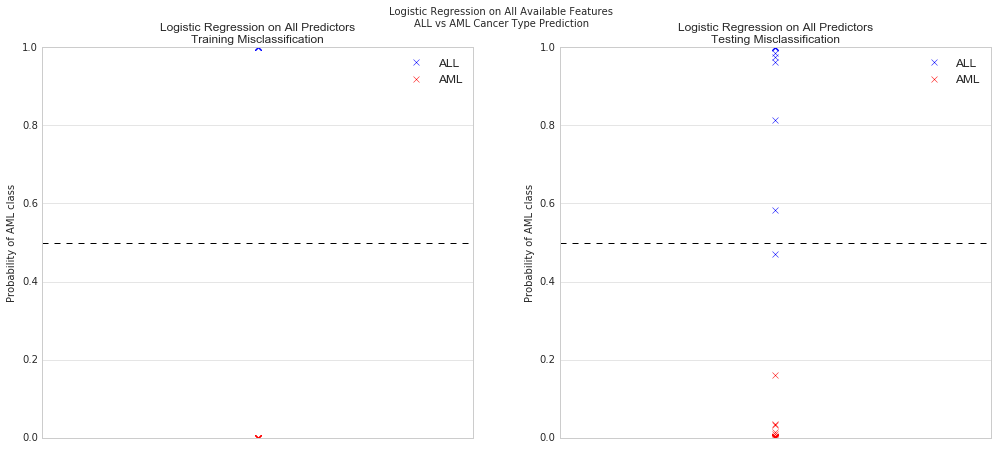

In [8]:
#from HW5_functions import visualize_prob
# define function in notebook bc not working right on import
def visualize_prob(model, x, y, ax):
    '''
    A function to visualize the probabilities predicted by a Logistic Regression model
    
    Inputs:
    -------------------------------------------------
    model: (Logistic regression model)
    x: (n x d array of predictors in training data)
    y: (n x 1 array of response variable vals in training data: 0 or 1)
    ax: (an axis object to generate the plot)
     
    Outputs:
    -------------------------------------------------
    None, prints out plot
    '''
    import numpy as np
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    #pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'ALL')
    #neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'AML')
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bx', label ='ALL')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'rx', label = 'AML')
    
    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])
    
    return None

# run logistic regression
multi_logit = LogisticRegression(C=1e5)
multi_logit.fit(x_train, y_train)

# get logistic predictions
yhat_multilogit_train = multi_logit.predict(x_train.values)
yhat_multilogit_test = multi_logit.predict(x_test.values)

# get misclassification rates on train/test for logistic regression
misclass_rate_train_multlog = misclassification_rate(y_train, yhat_multilogit_train)
misclass_rate_test_multlog = misclassification_rate(y_test, yhat_multilogit_test)

print('''
Logistic Regression All X Variables
---------------------------------------
Training Misclassification Rate:  %.5f
Testing Misclassification Rate:  %.5f
''' %(misclass_rate_train_multlog, misclass_rate_test_multlog))

# plot misclassification on test and train
_, ax = plt.subplots(1, 2, figsize=(17, 7))
visualize_prob(multi_logit, x_train.values, y_train.values, ax[0])
ax[0].set_title('Logistic Regression on All Predictors\nTraining Misclassification')

visualize_prob(multi_logit, x_test.values, y_test.values, ax[1])
ax[1].set_title('Logistic Regression on All Predictors\nTesting Misclassification')

plt.suptitle('Logistic Regression on All Available Features\nALL vs AML Cancer Type Prediction')

### Multiple Logistic Regression: All $X$ Predictors

The logistic regression model fitted on all $X$ predictors performs much better than on the initial model built on the single gene predictor.  When observing the `visualize_prob` plots above, it is clear that there is a binary distribution in the training set (potentially indicating over-fitting) while the spread of the probabilities is more pronounced in the testing set (though it is still rather polarized).  There are a couple data points that are near probability of 0.5 for the test set plot; one of which is slightly below, and one is slightly above.  These points are the most uncertain categorizations in the test set.  The two models are summarized below.

##### Logistic Regression Fitted on `D29963_at`
- Training Misclassification Rate = 0.28125
- Testing Misclassification Rate = 0.17073

##### Logistic Regression Fitted on All $X$ Predictors
- Training Misclassification Rate:  0.00000
- Testing Misclassification Rate:  0.02439

## Part (d): Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 100 boostrap samples/iterations.  



C:\Users\pmwash\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:261: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indices = random_state.randint(0, n_samples, size=(max_n_samples,))



All Predictors = 7129
Significant Predictors = 1063
Percentage Significant = 0.14911


Logistic Regression w/ Significant Variables
---------------------------------------
Training Misclassification Rate:  0.00000
Testing Misclassification Rate:  0.02439



,mean,std,z_value,p(|z|),significant
coefficient_100_bootstrap_iterations,,,,,
AFFX-CreX-5_at,-0.025417,0.012163,-2.089783,0.018319,True
AFFX-BioB-3_st,-0.022308,0.009967,-2.238218,0.012603,True
AFFX-HUMISGF3A/M97935_5_at,0.019748,0.009708,2.034209,0.979035,True
AFFX-HUMISGF3A/M97935_MA_at,0.027349,0.009853,2.775775,0.997246,True
AFFX-HUMRGE/M10098_3_at,-0.038847,0.019371,-2.005439,0.022458,True


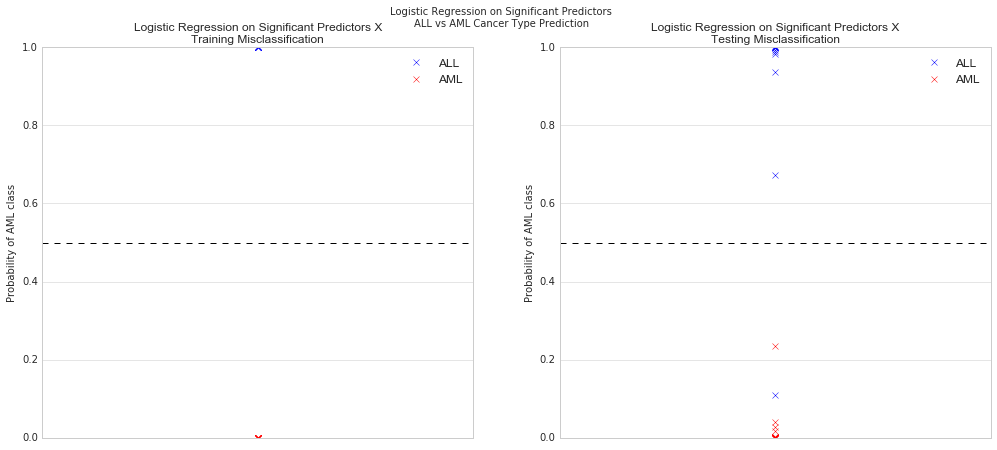

In [9]:
from sklearn.utils import resample
from scipy import stats

unlist = lambda l: [item for sublist in l for item in sublist]

def p_bootstrap_logit(x_train,  y_train, predictor_cols, iterations, sample_size, C, beta=.95, seed=777):
    '''
    Inputs:
    -------------------------------------------------
    x_train: training data set
    y_train: training labels
    predictor_cols: column names for preservation
    iterations: number of bootstrap iterations
    sample_size: percent of sample to use
    C: inverse lambda
    beta: 1 - alpha, level of significance
    
    Outputs:
    -------------------------------------------------
    p_df: pd.DataFrame of coef. mean, std error, p, z, significance
    '''
    # set seed
    np.random.seed(seed)
    
    # get degrees of freedom and split alpha for two-tail test
    split_alpha = (1 - beta) / 2
    critical_z = stats.norm.isf([0 + split_alpha, 1 - split_alpha])
    
    coef = {}
    n_samples = sample_size * len(x_train)
    
    for i in range(iterations):
        # perform resampling
        x_sample, y_sample = resample(x_train, y_train, replace=True, n_samples=n_samples)
        
        # fit logit model on sample
        logit_sample = LogisticRegression(C=C)
        logit_sample.fit(x_sample, y_sample)
        
        # save coefficients
        coef[i] = unlist(logit_sample.coef_.tolist())
    
    # organize coefficients into pd.DataFrame, divide by std
    p_df = pd.DataFrame(coef, index=predictor_cols).T
    p_df = pd.DataFrame({'mean':p_df.mean(), 'std':p_df.std()})
    p_df.index.name = 'coefficient_100_bootstrap_iterations'
    p_df['z_value'] = np.divide(p_df['mean'], p_df['std'])
    p_df['p(|z|)'] = stats.norm.cdf(p_df['z_value'])
    p_df['significant'] = (p_df['z_value'] < min(critical_z)) | (p_df['z_value'] > max(critical_z))  
    #p_df['significant'] = (p_df['p(|z|)'] > .975) | (p_df['p(|z|)'] < .025)
    
    return p_df

coef_df = p_bootstrap_logit(x_train,  y_train, predictor_cols, iterations=100, sample_size=0.75, C=1e5, beta=.95)

# compare number before and after
p_before = len(coef_df.index)
sig_coef_df = coef_df[coef_df.significant == True]
p_after = len(sig_coef_df.index)
pct_significant = p_after / p_before

print('''
All Predictors = %i
Significant Predictors = %i
Percentage Significant = %.5f
''' %(p_before, p_after, pct_significant))

# fit logit on only significant predictors
sig_cols = sig_coef_df.index.values.tolist()
logit_sig = LogisticRegression(C=1e5)
logit_sig.fit(x_train[sig_cols], y_train)

# get logistic predictions
yhat_siglogit_train = logit_sig.predict(x_train[sig_cols].values)
yhat_siglogit_test = logit_sig.predict(x_test[sig_cols].values)

# get misclassification rates on train/test for logistic regression
misclass_rate_train_siglog = misclassification_rate(y_train, yhat_siglogit_train)
misclass_rate_test_siglog = misclassification_rate(y_test, yhat_siglogit_test)

print('''
Logistic Regression w/ Significant Variables
---------------------------------------
Training Misclassification Rate:  %.5f
Testing Misclassification Rate:  %.5f
''' %(misclass_rate_train_siglog, misclass_rate_test_siglog))

_, ax = plt.subplots(1, 2, figsize=(17, 7))
visualize_prob(logit_sig, x_train[sig_cols].values, y_train.values, ax[0])
ax[0].set_title('Logistic Regression on Significant Predictors X\nTraining Misclassification')

visualize_prob(logit_sig, x_test[sig_cols].values, y_test.values, ax[1])
ax[1].set_title('Logistic Regression on Significant Predictors X\nTesting Misclassification')

plt.suptitle('Logistic Regression on Significant Predictors\nALL vs AML Cancer Type Prediction')

# display dataframe of significant coefficients
sig_coef_df.head()

### Analyzing Significant Coefficients 

When selecting only the significant coefficients in the all-predictors model we go from 7129 $X$ variables to just 1063, about 15% of the original number.  These coefficients were determined by using 100 rounds of bootstrap sampling at a significance level of 95%.

## Part (e): Dimensionality Reduction using PCA

A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the first set of principal components contributing to 90% of the variance in the predictors.

- Fit the model on PCA components mentioned above.  How do the classification accuracy values on both the training and tests sets compare with the models fitted in Parts (c) and (d)?  

- Re-fit a logistic regression model using 5-fold cross-validation to choose the number of principal components that maximizes accuracy, and comment on whether you get better test performance than the model fitted above (explain your observations). 

- Use the code provided in Part (c) to visualize the probabilities predicted by the fitted models on both the training and test sets. How does the spread of probabilities in these plots compare to those for the models in Part (c) and (d)? 



Logistic Regression on Top 23 Principal Components
---------------------------------------
Training Misclassification Rate:  0.00000
Testing Misclassification Rate:  0.02439



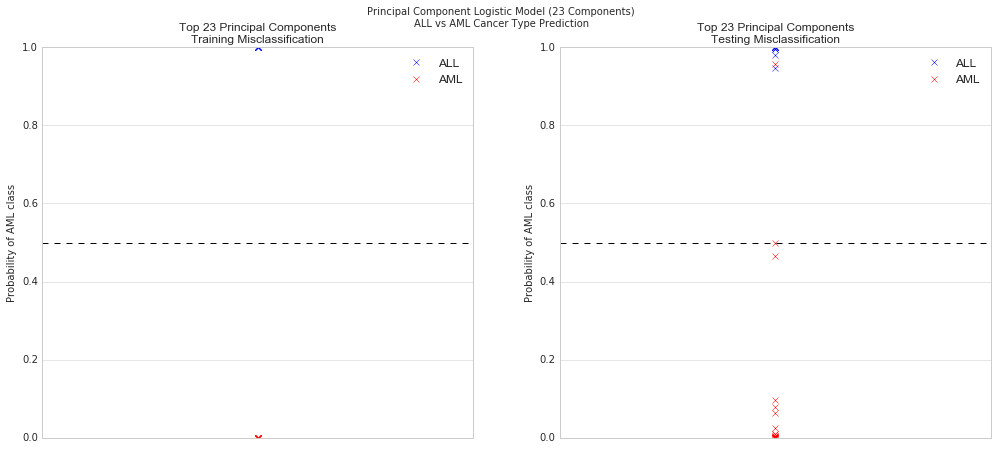

In [10]:
from sklearn.model_selection import KFold

# specify/fit that 90% of variance is desired to be covered
pca = PCA(n_components=.90)
pca.fit(x_train)

# transform x_train into PCA that covers 90%
x_train_pca = pd.DataFrame(pca.transform(x_train))
x_train_pca.columns = ['pca_' + str(i) for i in np.arange(1, len(x_train_pca.columns)+1)]
x_test_pca = pd.DataFrame(pca.transform(x_test))
x_test_pca.columns = ['pca_' + str(i) for i in np.arange(1, len(x_test_pca.columns)+1)]

# reset indices for random indexing
x_train_pca.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

# define KFold and run 5 splits; run KFold cross-validation on transformed x_train_pca
kfolds = KFold(n_splits=5, random_state=777)
pca_components = {}

training_cols = []
for i, col in enumerate(x_train_pca.columns):
    
    # iteratively build up misclassifications and training_col set
    misclassifications = []
    training_cols.append(col)
    
    for train_ix, val_ix in kfolds.split(x_train_pca[training_cols]):
        x_trn, x_val = x_train_pca.loc[train_ix, training_cols], x_train_pca.loc[val_ix, training_cols]
        y_trn, y_val = y_train[train_ix], y_train[val_ix]

        # fit model
        logit = LogisticRegression()
        logit.fit(x_trn, y_trn)

        # validate model
        yhat_val = logit.predict(x_val)
        misclassifications.append(misclassification_rate(y_val, yhat_val))
        
    # save all five folds results
    pca_components[i] = misclassifications

# organize data into pd.DataFrame for analysis
misclass_df = pd.DataFrame(pca_components).T
misclass_df.columns = ['fold_' + str(i) for i in np.arange(1, 6)]
misclass_df.set_index(np.arange(1, len(misclass_df.index)+1), inplace=True, drop=True)
misclass_df.index.name = 'n_pca'
misclass_df = misclass_df.T

# evaluate model trained on all principal components
logit_pca = LogisticRegression(C=1e5)

# top 23 pc's cover 90%
top = ['pca_' + str(i) for i in np.arange(1, 24)]
logit_pca.fit(x_train_pca[top], y_train)

# get logistic predictions
yhat_pca_train = logit_pca.predict(x_train_pca[top].values)
yhat_pca_test = logit_pca.predict(x_test_pca[top].values)

# get misclassification rates on train/test for logistic regression
misclass_rate_train_pca = misclassification_rate(y_train, yhat_pca_train)
misclass_rate_test_pca = misclassification_rate(y_test, yhat_pca_test)

print('''
Logistic Regression on Top 23 Principal Components
---------------------------------------
Training Misclassification Rate:  %.5f
Testing Misclassification Rate:  %.5f
''' %(misclass_rate_train_pca, misclass_rate_test_pca))

# plot top 23 pca outcome
_, ax = plt.subplots(1, 2, figsize=(17, 7))
visualize_prob(logit_pca, x_train_pca[top].values, y_train.values, ax[0])
ax[0].set_title('Top 23 Principal Components\nTraining Misclassification')

visualize_prob(logit_pca, x_test_pca[top].values, y_test.values, ax[1])
ax[1].set_title('Top 23 Principal Components\nTesting Misclassification')

plt.suptitle('Principal Component Logistic Model (23 Components)\nALL vs AML Cancer Type Prediction')

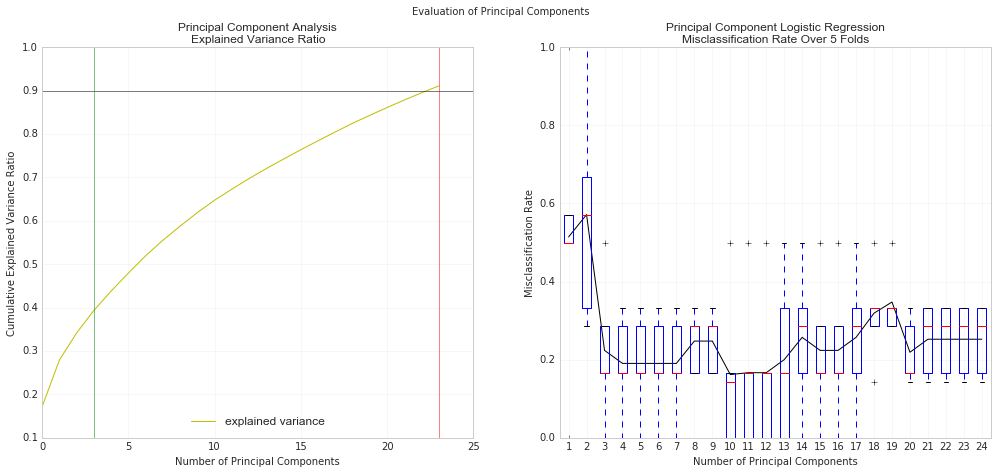

In [11]:
# plot PCA summary to decide which is best
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

# plot first axis
ax[0].plot(np.cumsum(pca.explained_variance_ratio_), c='y', label='explained variance')
ax[0].axhline(0.9, c='black', alpha=0.5)
ax[0].axvline(23, c='red', alpha=0.5)
ax[0].axvline(3, c='green', alpha=0.5)
ax[0].set_xlabel('Number of Principal Components')
ax[0].set_ylabel('Cumulative Explained Variance Ratio')
ax[0].set_title('Principal Component Analysis\nExplained Variance Ratio')
ax[0].legend(loc='best')
ax[0].grid(alpha=0.3)
plt.style.use('seaborn-whitegrid')

# plot second axis
misclass_df.mean().plot(title='Principal Component Logistic Regression\nMisclassification Rate Over 5 Folds', ax=ax[1], color='Black')
misclass_df.boxplot(return_type='dict')
ax[1].grid(alpha=0.3)
ax[1].set_xlabel('Number of Principal Components')
ax[1].set_ylabel('Misclassification Rate')

plt.suptitle('Evaluation of Principal Components')


KFolds Mean Validation Misclassification Rate for Top 3 Principal Components = 0.22381


Logistic Regression on Top 3 Principal Components
---------------------------------------
Training Misclassification Rate:  0.15625
Testing Misclassification Rate:  0.07317



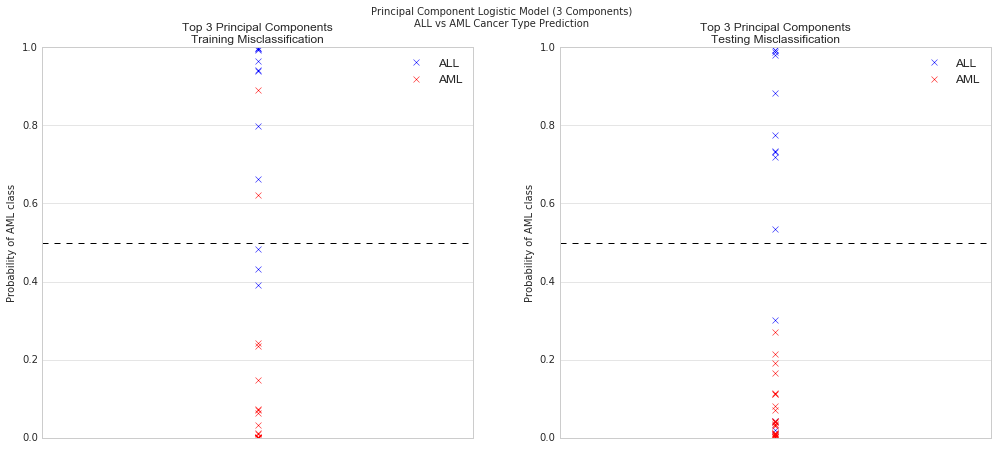

In [12]:
# show PCA = 3 description
print('''
KFolds Mean Validation Misclassification Rate for Top 3 Principal Components = %.5f
''' %misclass_df[3].mean())

# retrain model on top 3 principal components
logit_pca3 = LogisticRegression(C=1e5)
top3 = ['pca_' + str(i) for i in np.arange(1, 4)]
logit_pca3.fit(x_train_pca[top3], y_train)

# get logistic predictions
yhat_pca3_train = logit_pca3.predict(x_train_pca[top3].values)
yhat_pca3_test = logit_pca3.predict(x_test_pca[top3].values)

# get misclassification rates on train/test for logistic regression
misclass_rate_train_pca3 = misclassification_rate(y_train, yhat_pca3_train)
misclass_rate_test_pca3 = misclassification_rate(y_test, yhat_pca3_test)

print('''
Logistic Regression on Top 3 Principal Components
---------------------------------------
Training Misclassification Rate:  %.5f
Testing Misclassification Rate:  %.5f
''' %(misclass_rate_train_pca3, misclass_rate_test_pca3))

_, ax = plt.subplots(1, 2, figsize=(17, 7))
visualize_prob(logit_pca3, x_train_pca[top3].values, y_train.values, ax[0])
ax[0].set_title('Top 3 Principal Components\nTraining Misclassification')

visualize_prob(logit_pca3, x_test_pca[top3].values, y_test.values, ax[1])
ax[1].set_title('Top 3 Principal Components\nTesting Misclassification')

plt.suptitle('Principal Component Logistic Model (3 Components)\nALL vs AML Cancer Type Prediction')

### Comparing  Logistic Regression Models:
#### All Dimensions, Significant Dimensions, and Top 23 Principal Components

Interestingly the models fit in parts (c), (d) and the first part of part (e) have identical training and test set misclassification rates.  These three models likely suffer from the curse of dimensionality, wherein the available data exhibits high degrees of dimensionality with limited observations.  Recall that the training data only has 32 observations and 7129 original predictors, making it difficult to learn a true "state of nature" due to limited observations.  The model fit only on the significant predictors suffered from the same issue, despite containing 1063 (about 15% of the original) predictors.  Even when we distill down to 23 principal components (covering 90% of the variation in the predictors) the same phenomenon is observed.  This makes sense in that the top 23 principal components are simply projections from the original 7129 dimensions.

##### Part C: Logistic Regression w/ All Variables 
- Training Misclassification Rate:  0.00000
- Testing Misclassification Rate:  0.02439

##### Part D: Logistic Regression w/ Significant Variables
- Training Misclassification Rate:  0.00000
- Testing Misclassification Rate:  0.02439

##### Part E: Logistic Regression on Top 23 Principal Components
- Training Misclassification Rate:  0.00000
- Testing Misclassification Rate:  0.02439


### PCA Dimensionality Reduction - Choosing the Best `n_pca`

In the boxplot above which depicts the mean (and dispersion) of the misclassification rate in the validation data (using 5 `KFolds` trials per group of principal components) it is clear that the first three principal components reduce the misclassification rate on the validation set dramatically.  Beyond 3 principal components the benefit is minimal, where a minimum is reached at 10 principal components.  

Given the fact that there are extremely limited observations, and that it is desired that the model generalize well beyond these data, the model trained on three principal components is chosen as the best.  The model does not perform as well on the training nor the test data, likely due to the fact that the top three PCs only explain about 40% of the variance in the training data.  However it is encouraging to note that the testing misclassification rate decreased by more than half when compared with the training set, which is an encouraging sign for further generalization.  Also encouraging is the increased entropy in the probabilities generated (as shown on the "Training Misclassification" plots) compared with the models fitted on large numbers of dimensions, making the predicted probabilities much less polarized.

The results from this model are summarized below.

##### Part E: Logistic Regression on Top 3 Principal Components
- Training Misclassification Rate:  0.15625
- Testing Misclassification Rate:  0.07317

### Comparing Spread of Probabilities

It is clear that the spread of probabilities for the top-3 model, when compared against the other high-dimension models, is considerably less polarized.  This allows for some uncertainty in the classification, which in-turn allows for tweaks to the model to more effectively deal with undersireable false positives or false negatives.  Given the inherent difficulty in interpreting this high-dimensional data this characteristic is desireable over high levels of certainty (in the higher-dimension models) that lack any sort of intuition of scientific explanation.

---
 

# APCOMP209a - Homework Question

Suppose we want to conduct PCA on the model matrix $X \in \Re^{n×p}$, where the columns have been suitably set to zero mean. In this question, we consider the squared reconstruction error:

$$  \parallel XQ- XQ_m \parallel ^2 $$

for a suitable set of eigenvectors forming the matrix $Q_m$, as discussed below. Suppose that we conduct eigendecomposition of $X^T X$ and obtain eigenvalues $\lambda_1, \ldots , \lambda_p$ and principal components $Q$, i.e.

$$ X^T X = Q \Lambda Q ^T $$

(1) Suppose that the matrix norm is simply the squared dot product, namely

$$ \parallel A \parallel ^2 = A^T A $$

Then, express the reconstruction error as a sum of matrix products.

(2) Simplify your result from (1) based on properties of the matrices $Q$.

(3) Now let $Q_m$ be the matrix of the first $m < p$ eigenvectors, namely

$$ Q_m = (q_1, \ldots, q_m, 0, \ldots, 0) \in \Re^{p \times p} $$

Thus, $X Q_m$ is the PCA projection of the data into the space spanned by the first $m$ principal components. Express the products $Q^T_m Q$ and $Q^T Q_m$, again using properties of the eigenbasis $q_1, \ldots, q_p$.

(4) Use your results from (3) to finally fully simplify your expression from (2).

(5) Note that the result you obtain should still be a matrix, i.e. this does not define a proper norm on the space of matrices (since the value should be a scalar). Consequently, the true matrix norm is actually the trace of the
above result, namely

$$ \parallel A \parallel ^2  = {\rm trace} (A^T A) $$
Use your result from (4) and this new definition to find a simple expression
for the reconstruction error in terms of the eigenvalues.

(6) Interpret your result from (5). In light of your results, does our procedure for PCA (selecting the $m$ substantially larger eigenvalues) make sense? Why or why not?